# SELFIES 토큰 등장 빈도 분석

Train/Val/Test dataset에서 SELFIES 토큰의 등장 빈도를 분석합니다:
1. **Input (Prompt)** 부분의 SELFIES 토큰 등장 빈도
2. **Response (Output)** 부분의 SELFIES 토큰 등장 빈도
3. **Total (Input + Response)** 합산 등장 빈도

In [1]:
import re
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_from_disk, concatenate_datasets

# 시각화 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

/opt/conda/envs/MolDA_CHJ/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 설정

In [2]:
# 데이터셋 경로
DATASET_PATHS = {
    'train': '/app/Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_512_Truncation_merged_bace_chebi_mol2text_chebi_text2mol_qm9_homo',
    'val': '/app/Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_val_512_Truncation_merged_bace_chebi_mol2text_chebi_text2mol_qm9_homo',
    'test': '/app/Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_test_512_Truncation_merged_bace_chebi_mol2text_chebi_text2mol_qm9_homo',
}

# SELFIES 사전 경로
SELFIES_DICT_PATH = '/app/Mol-LLM_Custom/model/selfies_dict.txt'

# 분석할 상위 토큰 수
TOP_K = 100

## 2. 유틸리티 함수

In [3]:
def load_selfies_dict(selfies_dict_path: str) -> set:
    """SELFIES 토큰 사전 로드"""
    with open(selfies_dict_path, 'r') as f:
        tokens = {line.strip() for line in f.readlines() if line.strip()}
    return tokens


def extract_selfies_tokens(text: str, selfies_dict: set) -> List[str]:
    """
    텍스트에서 SELFIES 토큰 추출
    SELFIES 토큰은 [...] 형태: [C], [N], [=Branch1], [C@@H], [Ring1] 등
    """
    pattern = r'\[[^\]]+\]'
    matches = re.findall(pattern, text)
    selfies_tokens = [m for m in matches if m in selfies_dict]
    return selfies_tokens


def analyze_dataset(dataset_path: str, selfies_dict: set) -> Tuple[Counter, Counter, Counter]:
    """
    데이터셋 분석
    
    Returns:
        input_counter: Input(Prompt)에서의 토큰 빈도
        response_counter: Response(Output)에서의 토큰 빈도
        total_counter: 합산 빈도
    """
    print(f"Loading dataset from: {dataset_path}")
    dataset = load_from_disk(dataset_path)
    
    input_counter = Counter()
    response_counter = Counter()
    
    print(f"Analyzing {len(dataset)} samples...")
    
    for i, sample in enumerate(dataset):
        # Input (prompt_text) 분석
        prompt_text = sample.get('prompt_text', '')
        input_tokens = extract_selfies_tokens(prompt_text, selfies_dict)
        input_counter.update(input_tokens)
        
        # Response (target_text) 분석
        target_text = sample.get('target_text', '')
        response_tokens = extract_selfies_tokens(target_text, selfies_dict)
        response_counter.update(response_tokens)
        
        if (i + 1) % 10000 == 0:
            print(f"  Processed {i + 1}/{len(dataset)} samples...")
    
    total_counter = input_counter + response_counter
    print(f"Done! Input: {sum(input_counter.values()):,}, Response: {sum(response_counter.values()):,}, Total: {sum(total_counter.values()):,}")
    
    return input_counter, response_counter, total_counter

## 3. SELFIES 사전 로드

In [4]:
selfies_dict = load_selfies_dict(SELFIES_DICT_PATH)
print(f"SELFIES dictionary size: {len(selfies_dict)}")
print(f"Sample tokens: {list(selfies_dict)[:10]}")

SELFIES dictionary size: 2944
Sample tokens: ['[#13C-1]', '[197Po]', '[151Pm]', '[Ga]', '[#Lu]', '[107Cd]', '[IrH3]', '[98Tc+5]', '[B+2]', '[110Cd]']


## 4. 데이터셋 분석

In [5]:
# 모든 split 분석
results = {}

for split_name, dataset_path in DATASET_PATHS.items():
    print(f"\n{'='*60}")
    print(f"Analyzing {split_name.upper()} dataset")
    print(f"{'='*60}")
    
    input_counter, response_counter, total_counter = analyze_dataset(dataset_path, selfies_dict)
    results[split_name] = {
        'input': input_counter,
        'response': response_counter,
        'total': total_counter
    }


Analyzing TRAIN dataset
Loading dataset from: /app/Mol-LLM_Custom/dataset/train_official/GSAI-ML-LLaDA-8B-Instruct_string+graph_q32_train_512_Truncation_merged_bace_chebi_mol2text_chebi_text2mol_qm9_homo
Analyzing 170870 samples...
  Processed 10000/170870 samples...
  Processed 20000/170870 samples...
  Processed 30000/170870 samples...
  Processed 40000/170870 samples...
  Processed 50000/170870 samples...
  Processed 60000/170870 samples...
  Processed 70000/170870 samples...
  Processed 80000/170870 samples...
  Processed 90000/170870 samples...
  Processed 100000/170870 samples...
  Processed 110000/170870 samples...
  Processed 120000/170870 samples...
  Processed 130000/170870 samples...
  Processed 140000/170870 samples...
  Processed 150000/170870 samples...
  Processed 160000/170870 samples...
  Processed 170000/170870 samples...
Done! Input: 3,007,532, Response: 1,295,034, Total: 4,302,566

Analyzing VAL dataset
Loading dataset from: /app/Mol-LLM_Custom/dataset/train_offici

## 5. Train 데이터셋 상세 분석

In [6]:
def create_frequency_dataframe(counter: Counter, top_k: int = 100) -> pd.DataFrame:
    """Counter를 DataFrame으로 변환"""
    total_count = sum(counter.values())
    data = []
    cumulative = 0
    
    for rank, (token, count) in enumerate(counter.most_common(top_k), 1):
        ratio = count / total_count * 100 if total_count > 0 else 0
        cumulative += ratio
        data.append({
            'Rank': rank,
            'Token': token,
            'Count': count,
            'Ratio (%)': round(ratio, 2),
            'Cumulative (%)': round(cumulative, 2)
        })
    
    return pd.DataFrame(data)

In [7]:
# Train 데이터셋 기준 분석
train_input = results['train']['input']
train_response = results['train']['response']
train_total = results['train']['total']

print(f"\n{'='*80}")
print("TRAIN DATASET SUMMARY")
print(f"{'='*80}")
print(f"Input tokens:    {sum(train_input.values()):>12,}")
print(f"Response tokens: {sum(train_response.values()):>12,}")
print(f"Total tokens:    {sum(train_total.values()):>12,}")
print(f"\nUnique tokens in Input:    {len(train_input):,}")
print(f"Unique tokens in Response: {len(train_response):,}")
print(f"Unique tokens in Total:    {len(train_total):,}")


TRAIN DATASET SUMMARY
Input tokens:       3,007,532
Response tokens:    1,295,034
Total tokens:       4,302,566

Unique tokens in Input:    287
Unique tokens in Response: 286
Unique tokens in Total:    287


In [ ]:
# Total 상위 100개 토큰
print("\n" + "="*80)
print("TOTAL (Input + Response) - Top 100 Tokens")
print("="*80)
df_total = create_frequency_dataframe(train_total, TOP_K)
display(df_total)


TOTAL (Input + Response) - Top 100 Tokens


,Rank,Token,Count,Ratio (%),Cumulative (%)
0,1,[C],1677208,38.98,38.98
1,2,[O],414159,9.63,48.61
2,3,[Branch1],401010,9.32,57.93
3,4,[Ring1],388285,9.02,66.95
4,5,[=C],250640,5.83,72.78
...,...,...,...,...,...
95,96,[\Cl],18,0.00,99.98
96,97,[N@@+1],18,0.00,99.98
97,98,[/Cl],18,0.00,99.98
98,99,[#NH1+1],18,0.00,99.98


In [9]:
# Input 상위 100개 토큰
print("\n" + "="*80)
print("INPUT (Prompt) Only - Top 100 Tokens")
print("="*80)
df_input = create_frequency_dataframe(train_input, TOP_K)
display(df_input)


INPUT (Prompt) Only - Top 100 Tokens


,Rank,Token,Count,Ratio (%),Cumulative (%)
0,1,[C],1218617,40.52,40.52
1,2,[Ring1],314682,10.46,50.98
2,3,[Branch1],271146,9.02,60.00
3,4,[O],269748,8.97,68.97
4,5,[=C],157774,5.25,74.21
...,...,...,...,...,...
95,96,[\Cl],9,0.00,99.98
96,97,[N@@+1],9,0.00,99.98
97,98,[/Cl],9,0.00,99.98
98,99,[#NH1+1],9,0.00,99.98


In [10]:
# Response 상위 100개 토큰
print("\n" + "="*80)
print("RESPONSE (Output) Only - Top 100 Tokens")
print("="*80)
df_response = create_frequency_dataframe(train_response, TOP_K)
display(df_response)


RESPONSE (Output) Only - Top 100 Tokens


,Rank,Token,Count,Ratio (%),Cumulative (%)
0,1,[C],458591,35.41,35.41
1,2,[O],144411,11.15,46.56
2,3,[Branch1],129864,10.03,56.59
3,4,[=C],92866,7.17,63.76
4,5,[Ring1],73603,5.68,69.44
...,...,...,...,...,...
95,96,[\Cl],9,0.00,99.96
96,97,[N@@+1],9,0.00,99.96
97,98,[/Cl],9,0.00,99.96
98,99,[#NH1+1],9,0.00,99.96


## 6. 시각화

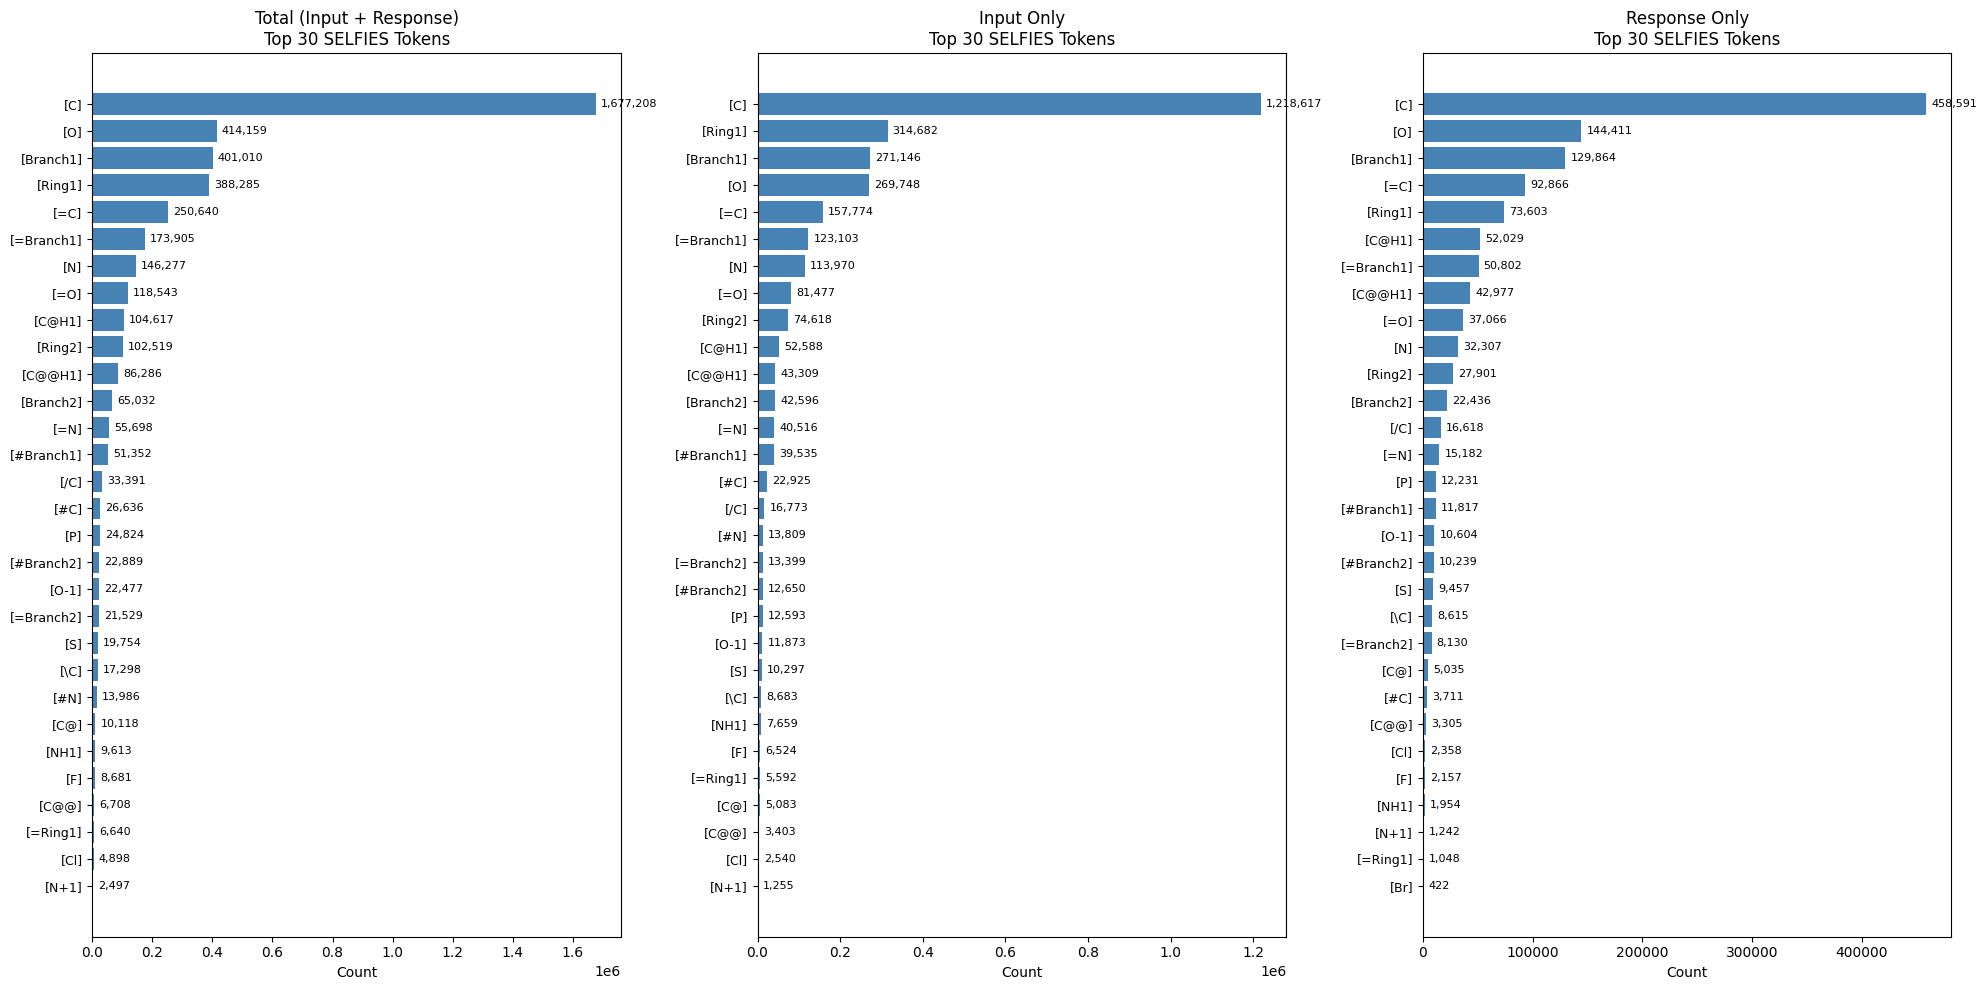

In [14]:
# 6.1 상위 30개 토큰 바 차트 비교
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for ax, (counter, title) in zip(axes, [
    (train_total, "Total (Input + Response)"),
    (train_input, "Input Only"),
    (train_response, "Response Only"),
]):
    top_tokens = counter.most_common(30)
    tokens = [t[0] for t in top_tokens]
    counts = [t[1] for t in top_tokens]
    
    bars = ax.barh(range(len(tokens)), counts, color='steelblue')
    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel('Count')
    ax.set_title(f'{title}\nTop 30 SELFIES Tokens', fontsize=12)
    
    # 값 표시
    for bar, count in zip(bars, counts):
        ax.text(bar.get_width() + max(counts) * 0.01, bar.get_y() + bar.get_height()/2,
               f'{count:,}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('/app/Mol-LLM_Custom/utils/selfies_analysis/top30_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

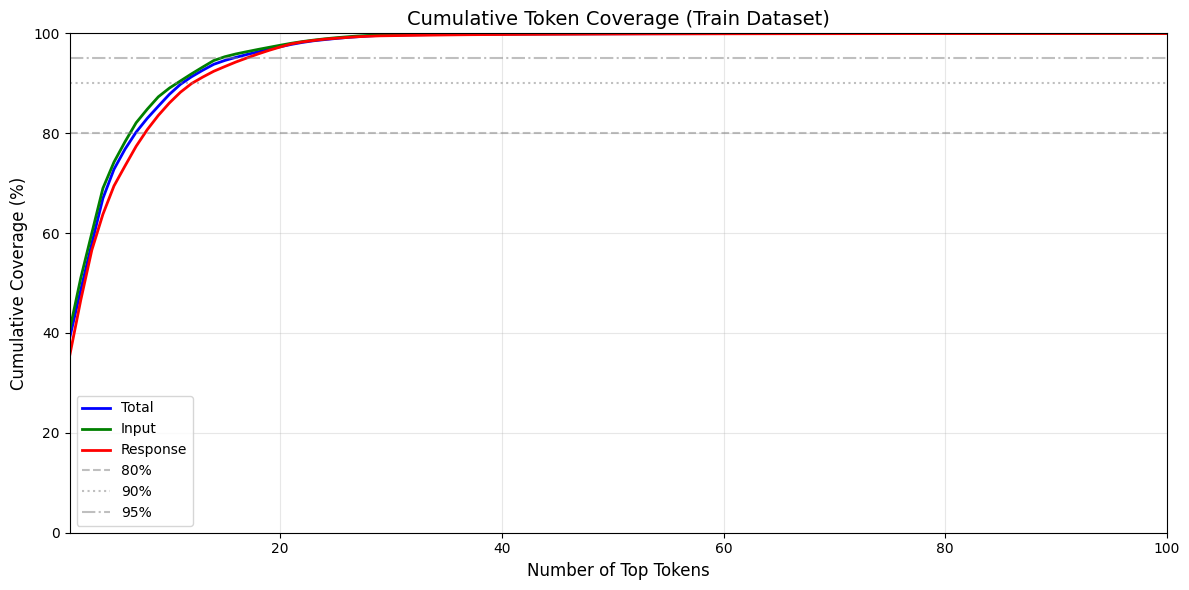

In [15]:
# 6.2 누적 커버리지 그래프
fig, ax = plt.subplots(figsize=(12, 6))

for counter, label, color in [
    (train_total, 'Total', 'blue'),
    (train_input, 'Input', 'green'),
    (train_response, 'Response', 'red'),
]:
    total_count = sum(counter.values())
    if total_count == 0:
        continue
    
    top_tokens = counter.most_common(min(TOP_K, len(counter)))
    cumulative = []
    cum_sum = 0
    for _, count in top_tokens:
        cum_sum += count / total_count * 100
        cumulative.append(cum_sum)
    
    ax.plot(range(1, len(cumulative) + 1), cumulative, label=label, color=color, linewidth=2)

ax.axhline(y=80, color='gray', linestyle='--', alpha=0.5, label='80%')
ax.axhline(y=90, color='gray', linestyle=':', alpha=0.5, label='90%')
ax.axhline(y=95, color='gray', linestyle='-.', alpha=0.5, label='95%')

ax.set_xlabel('Number of Top Tokens', fontsize=12)
ax.set_ylabel('Cumulative Coverage (%)', fontsize=12)
ax.set_title('Cumulative Token Coverage (Train Dataset)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(1, TOP_K)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('/app/Mol-LLM_Custom/utils/selfies_analysis/cumulative_coverage.png', dpi=150, bbox_inches='tight')
plt.show()

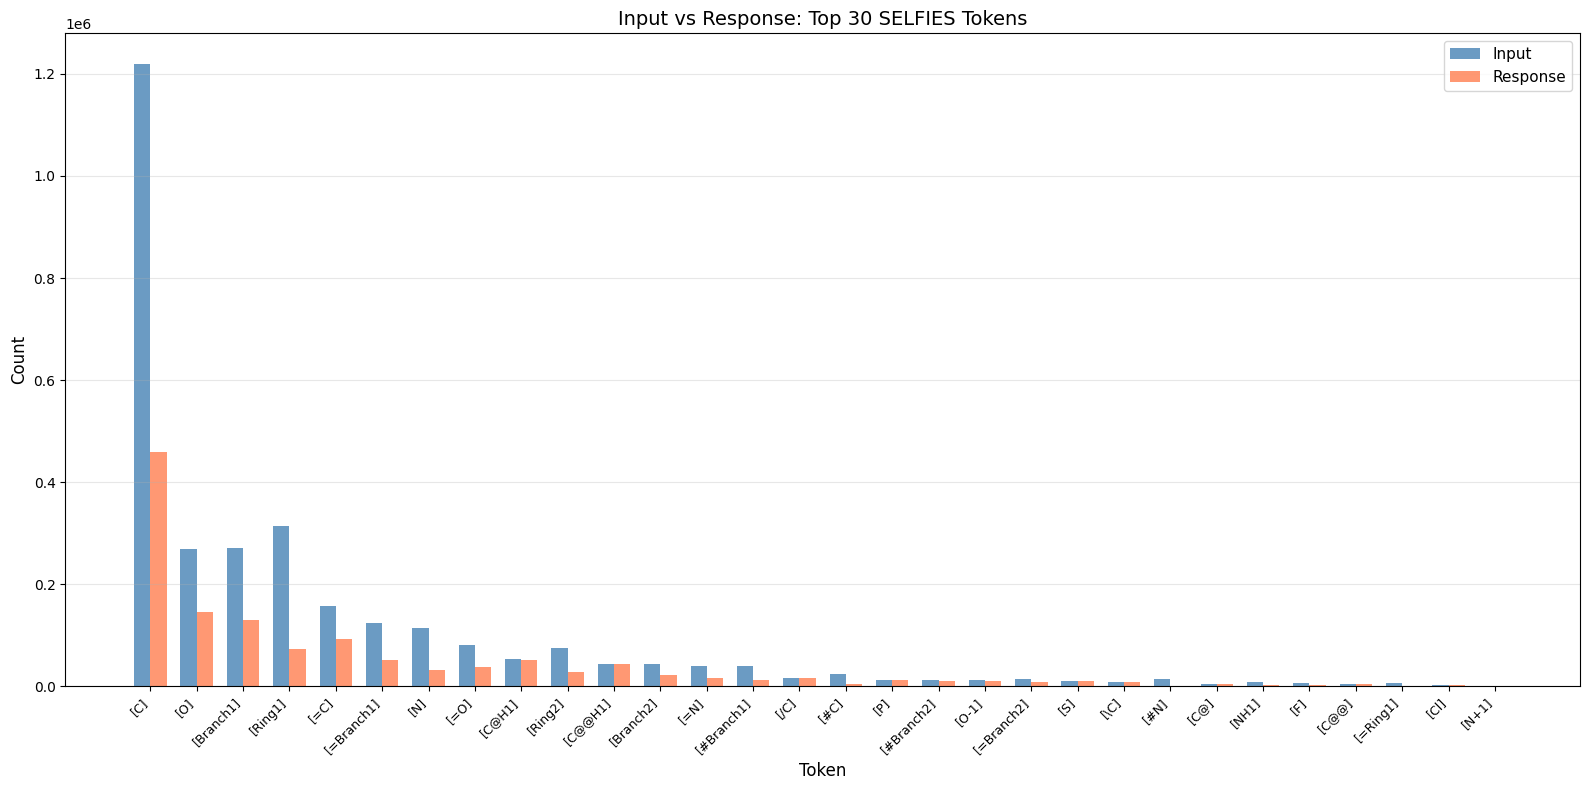

In [16]:
# 6.3 Input vs Response 비교 (상위 30개 토큰)
fig, ax = plt.subplots(figsize=(16, 8))

top_tokens = [t[0] for t in train_total.most_common(30)]
input_counts = [train_input.get(t, 0) for t in top_tokens]
response_counts = [train_response.get(t, 0) for t in top_tokens]

x = np.arange(len(top_tokens))
width = 0.35

bars1 = ax.bar(x - width/2, input_counts, width, label='Input', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, response_counts, width, label='Response', color='coral', alpha=0.8)

ax.set_xlabel('Token', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Input vs Response: Top 30 SELFIES Tokens', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(top_tokens, rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/app/Mol-LLM_Custom/utils/selfies_analysis/input_vs_response.png', dpi=150, bbox_inches='tight')
plt.show()

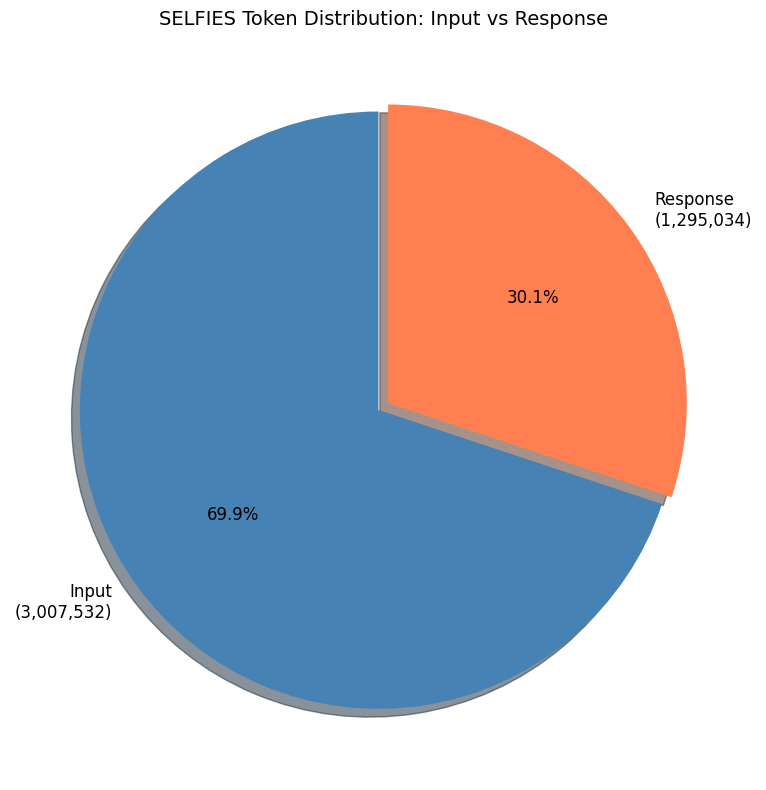

In [17]:
# 6.4 Input vs Response 비율 파이 차트
fig, ax = plt.subplots(figsize=(8, 8))

input_total = sum(train_input.values())
response_total = sum(train_response.values())

if input_total + response_total > 0:
    sizes = [input_total, response_total]
    labels = [f'Input\n({input_total:,})', f'Response\n({response_total:,})']
    colors = ['steelblue', 'coral']
    explode = (0.02, 0.02)
    
    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
           shadow=True, startangle=90, textprops={'fontsize': 12})
    ax.set_title('SELFIES Token Distribution: Input vs Response', fontsize=14)

plt.tight_layout()
plt.savefig('/app/Mol-LLM_Custom/utils/selfies_analysis/input_response_ratio.png', dpi=150, bbox_inches='tight')
plt.show()

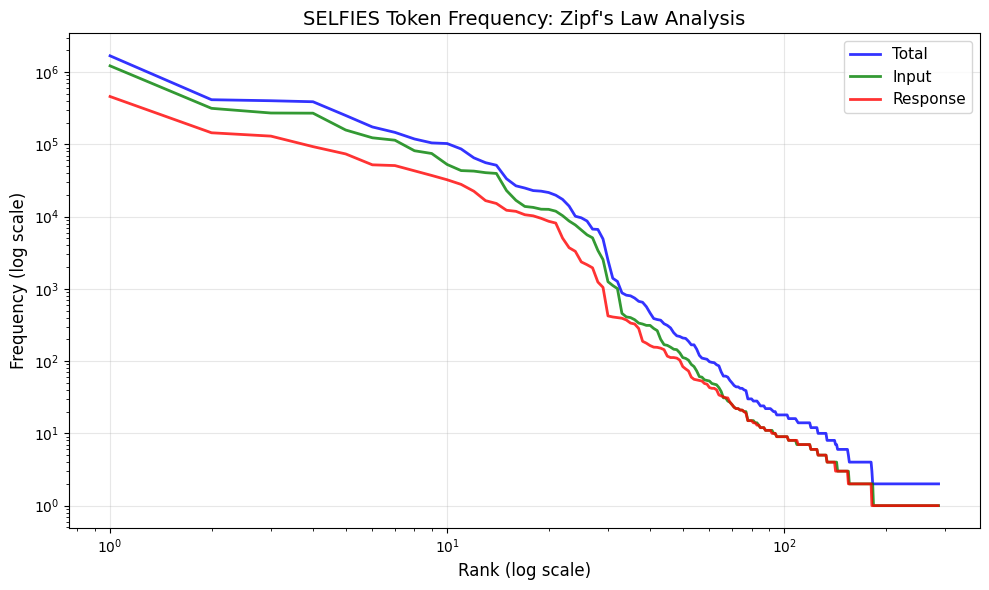

In [18]:
# 6.5 Zipf's Law 분석 (Log-Log Plot)
fig, ax = plt.subplots(figsize=(10, 6))

for counter, label, color in [
    (train_total, 'Total', 'blue'),
    (train_input, 'Input', 'green'),
    (train_response, 'Response', 'red'),
]:
    if not counter:
        continue
    
    sorted_counts = sorted(counter.values(), reverse=True)
    ranks = range(1, len(sorted_counts) + 1)
    
    ax.loglog(ranks, sorted_counts, label=label, color=color, linewidth=2, alpha=0.8)

ax.set_xlabel('Rank (log scale)', fontsize=12)
ax.set_ylabel('Frequency (log scale)', fontsize=12)
ax.set_title("SELFIES Token Frequency: Zipf's Law Analysis", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/app/Mol-LLM_Custom/utils/selfies_analysis/zipf_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

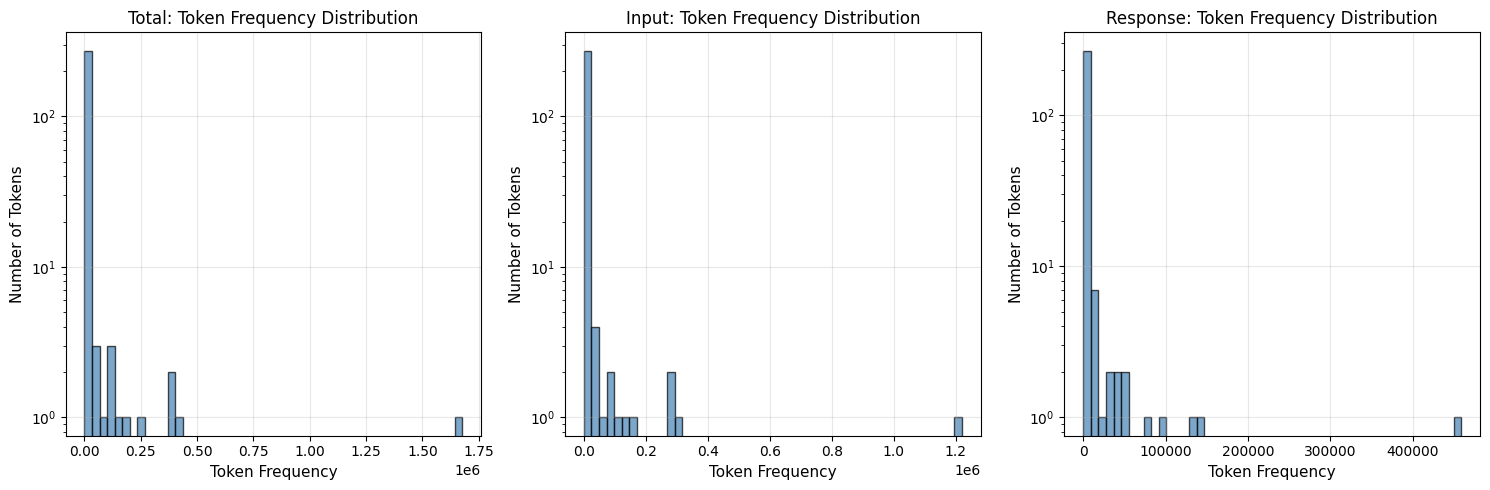

In [19]:
# 6.6 토큰 빈도 분포 히스토그램
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (counter, title) in zip(axes, [
    (train_total, "Total"),
    (train_input, "Input"),
    (train_response, "Response"),
]):
    counts = list(counter.values())
    if counts:
        ax.hist(counts, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Token Frequency', fontsize=11)
        ax.set_ylabel('Number of Tokens', fontsize=11)
        ax.set_title(f'{title}: Token Frequency Distribution', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/app/Mol-LLM_Custom/utils/selfies_analysis/frequency_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. 커버리지 분석

In [20]:
# 80%, 90%, 95% 커버리지에 필요한 토큰 수
print("\n" + "="*80)
print("COVERAGE ANALYSIS")
print("="*80)

for counter, name in [(train_total, "Total"), (train_input, "Input"), (train_response, "Response")]:
    total = sum(counter.values())
    if total == 0:
        continue
    
    cum_sum = 0
    tokens_for_80 = 0
    tokens_for_90 = 0
    tokens_for_95 = 0
    
    for rank, (_, count) in enumerate(counter.most_common(), 1):
        cum_sum += count / total * 100
        if cum_sum >= 80 and tokens_for_80 == 0:
            tokens_for_80 = rank
        if cum_sum >= 90 and tokens_for_90 == 0:
            tokens_for_90 = rank
        if cum_sum >= 95 and tokens_for_95 == 0:
            tokens_for_95 = rank
            break
    
    print(f"\n{name}:")
    print(f"  - 80% coverage: {tokens_for_80} tokens")
    print(f"  - 90% coverage: {tokens_for_90} tokens")
    print(f"  - 95% coverage: {tokens_for_95} tokens")
    print(f"  - Total unique tokens: {len(counter)}")


COVERAGE ANALYSIS

Total:
  - 80% coverage: 7 tokens
  - 90% coverage: 12 tokens
  - 95% coverage: 16 tokens
  - Total unique tokens: 287

Input:
  - 80% coverage: 7 tokens
  - 90% coverage: 11 tokens
  - 95% coverage: 15 tokens
  - Total unique tokens: 287

Response:
  - 80% coverage: 8 tokens
  - 90% coverage: 13 tokens
  - 95% coverage: 17 tokens
  - Total unique tokens: 286


## 8. Input Only / Response Only 토큰 분석

In [21]:
# Input에만 있는 토큰 vs Response에만 있는 토큰
input_only = set(train_input.keys()) - set(train_response.keys())
response_only = set(train_response.keys()) - set(train_input.keys())
both = set(train_input.keys()) & set(train_response.keys())

print("\n" + "="*80)
print("UNIQUE TOKEN DISTRIBUTION")
print("="*80)
print(f"Tokens in Input only:    {len(input_only):>6} tokens")
print(f"Tokens in Response only: {len(response_only):>6} tokens")
print(f"Tokens in Both:          {len(both):>6} tokens")


UNIQUE TOKEN DISTRIBUTION
Tokens in Input only:         1 tokens
Tokens in Response only:      0 tokens
Tokens in Both:             286 tokens


In [22]:
# Input에만 있는 토큰 상위 20개
if input_only:
    print("\nTop 20 tokens that appear ONLY in Input:")
    input_only_counter = Counter({t: train_input[t] for t in input_only})
    for i, (token, count) in enumerate(input_only_counter.most_common(20), 1):
        print(f"  {i:2}. {token:<20} {count:>8,}")


Top 20 tokens that appear ONLY in Input:
   1. [N@H1+1]                    2


In [23]:
# Response에만 있는 토큰 상위 20개
if response_only:
    print("\nTop 20 tokens that appear ONLY in Response:")
    response_only_counter = Counter({t: train_response[t] for t in response_only})
    for i, (token, count) in enumerate(response_only_counter.most_common(20), 1):
        print(f"  {i:2}. {token:<20} {count:>8,}")

## 9. 결과 저장

In [24]:
# 출력 디렉토리 생성
import os
os.makedirs('/app/Mol-LLM_Custom/utils/selfies_analysis', exist_ok=True)

# CSV로 저장
df_total.to_csv('/app/Mol-LLM_Custom/utils/selfies_analysis/train_total_top100.csv', index=False)
df_input.to_csv('/app/Mol-LLM_Custom/utils/selfies_analysis/train_input_top100.csv', index=False)
df_response.to_csv('/app/Mol-LLM_Custom/utils/selfies_analysis/train_response_top100.csv', index=False)

print("Results saved to /app/Mol-LLM_Custom/utils/selfies_analysis/")

Results saved to /app/Mol-LLM_Custom/utils/selfies_analysis/


In [25]:
# 전체 결과를 텍스트 파일로 저장
with open('/app/Mol-LLM_Custom/utils/selfies_analysis/analysis_report.txt', 'w') as f:
    f.write("SELFIES Token Frequency Analysis Report\n")
    f.write("="*80 + "\n\n")
    
    # Summary
    f.write("SUMMARY\n")
    f.write("-"*40 + "\n")
    f.write(f"Total tokens (Input + Response): {sum(train_total.values()):,}\n")
    f.write(f"Input tokens:                    {sum(train_input.values()):,}\n")
    f.write(f"Response tokens:                 {sum(train_response.values()):,}\n")
    f.write(f"Unique tokens (Total):           {len(train_total):,}\n")
    f.write(f"Unique tokens (Input):           {len(train_input):,}\n")
    f.write(f"Unique tokens (Response):        {len(train_response):,}\n\n")
    
    # Top 100 for each
    for counter, title in [
        (train_total, "TOTAL (Input + Response)"),
        (train_input, "INPUT Only"),
        (train_response, "RESPONSE Only"),
    ]:
        total_count = sum(counter.values())
        f.write(f"\n{'='*80}\n")
        f.write(f"{title} - Top 100 Tokens\n")
        f.write(f"{'='*80}\n")
        f.write(f"{'Rank':<6} {'Token':<20} {'Count':>12} {'Ratio':>10} {'Cumulative':>12}\n")
        f.write(f"{'-'*60}\n")
        
        cumulative = 0
        for rank, (token, count) in enumerate(counter.most_common(100), 1):
            ratio = count / total_count * 100 if total_count > 0 else 0
            cumulative += ratio
            f.write(f"{rank:<6} {token:<20} {count:>12,} {ratio:>9.2f}% {cumulative:>11.2f}%\n")

print("Report saved to /app/Mol-LLM_Custom/utils/selfies_analysis/analysis_report.txt")

Report saved to /app/Mol-LLM_Custom/utils/selfies_analysis/analysis_report.txt
